# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [3]:
import os
import sys
from random import randint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# load the data table
df = pd.read_csv("../MinION/Taxonomy/Minion_read_based_annotations_genus.normalised.tsv.gz", sep='\t', compression='gzip')
df = df[df['taxonomy'].str.contains('k__Bacteria')]
df = df[~df['taxonomy'].str.endswith('s__')]
df = df[~df['taxonomy'].str.endswith('g__')]
df = df[~df['taxonomy'].str.contains('g__;')]
df = df.set_index('taxonomy')
df.index = df.index.str.split(';').str[-1]

df = df.T

df.head()

taxonomy,g__Candidatus Stahlbacteria,g__Candidatus Chromulinivorax,g__Bradymonas,g__Microvenator,g__Candidatus Acididesulfobacter,g__Candidatus Acidulodesulfobacterium,g__Acanthopleuribacter,g__Candidatus Sulfopaludibacter,g__Edaphobacter,g__Granulicella,...,g__Coraliomargarita,g__Pelagicoccus,g__Puniceicoccus,g__Chthoniobacter,g__Pedosphaera,g__Akkermansia,g__Brevifollis,g__Luteolibacter,g__Verrucomicrobium,g__Candidatus Eremiobacter
825012_20181120_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
698917_20171207_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1586713_20180309_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
748160_20180321_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1593973_20180504_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.775989,0.0


In [5]:
# Load metadata table
metadata = pd.read_csv("../MinION/Metadata/FINAL_METADATA_MINION.csv.gz", encoding='windows-1252', compression='gzip', index_col=0)
if metadata.shape[0] != df.shape[0]:
    print("ERROR: your metadata is probably from the minion data and not the MGI data. Please double check!", file=sys.stderr)
metadata.head()

,#NAME,minion_ID,MGI_ID_from_fastq.gz,Patient,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,Sample type,DNA_extraction_ conc,#NAME.1,ULN,Sample name,Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total_Clusters_Passing_Filter_(Million)
#NAME_From sequences,,,,,,,,,,,,,,,,,,,,,
623361_20180123_S,623361_20180123_S,623361_20180123_S,623361_20180123_S,623361,23/01/2018,OP,RAH,Chest Clinic 9,18,4,...,Sputum,0.778,623361_20180123_S,SAGCFN_22_01764,623361_20180123_S,33.60,GAGATTCC,GGCTCTGA,468,2.4
639354_20171206_S,639354_20171206_S,639354_20171206_S,639354_20171206_S,639354,6/12/2017,IP,WCH,Adolescent 10,17,3,...,Sputum,3.540,639354_20171206_S,SAGCFN_22_01742,639354_20171206_S,20.80,ATTACTCG,TAATCTTA,337,4.9
642660_20180601_S,642660_20180601_S,642660_20180601_S,642660_20180601_S,642660,1/06/2018,IP,WCH,Adol Rm 11,17,3,...,Sputum,0.538,642660_20180601_S,SAGCFN_22_01780,642660_20180601_S,21.80,GAATTCGT,GGCTCTGA,491,4.8
650003_20180207_S,650003_20180207_S,650003_20180207_S,650003_20180207_S,650003,7/02/2018,IP,WCH,Adol Room 1,17,3,...,Sputum,0.552,650003_20180207_S,SAGCFN_22_01778,650003_20180207_S,8.28,GAATTCGT,ATAGAGGC,476,5.7
658355_20171204_S,658355_20171204_S,658355_20171204_S,658355_20171204_S,658355,4/12/2017,OP,WCH,Gilbert S Meeting,16,3,...,Sputum,0.433,658355_20171204_S,SAGCFN_22_01789,658355_20171204_S,16.60,CTGAAGCT,AGGCGAAG,507,4.5


In [6]:
# Map colors based on the metadata column
colours = np.where(metadata['CMS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

<Axes: xlabel='g__Pseudomonas', ylabel='Density'>

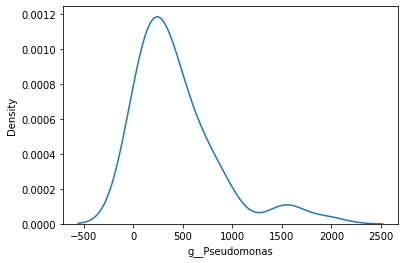

In [7]:
sns.kdeplot(data=df['g__Pseudomonas'])

In [8]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'g__Pseudomonas'
nonzeromean = np.mean(df[df[genus] > 0])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=marker_shapes))

In [9]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

,PC1,PC2
taxonomy,,
g__Streptococcus,-204.491242,7.360812
g__Staphylococcus,90.443682,-10.422926
g__Bacillus,50.601427,29.651821
g__Gemella,-42.725028,-69.333763
g__Prevotella,20.584983,-120.752479


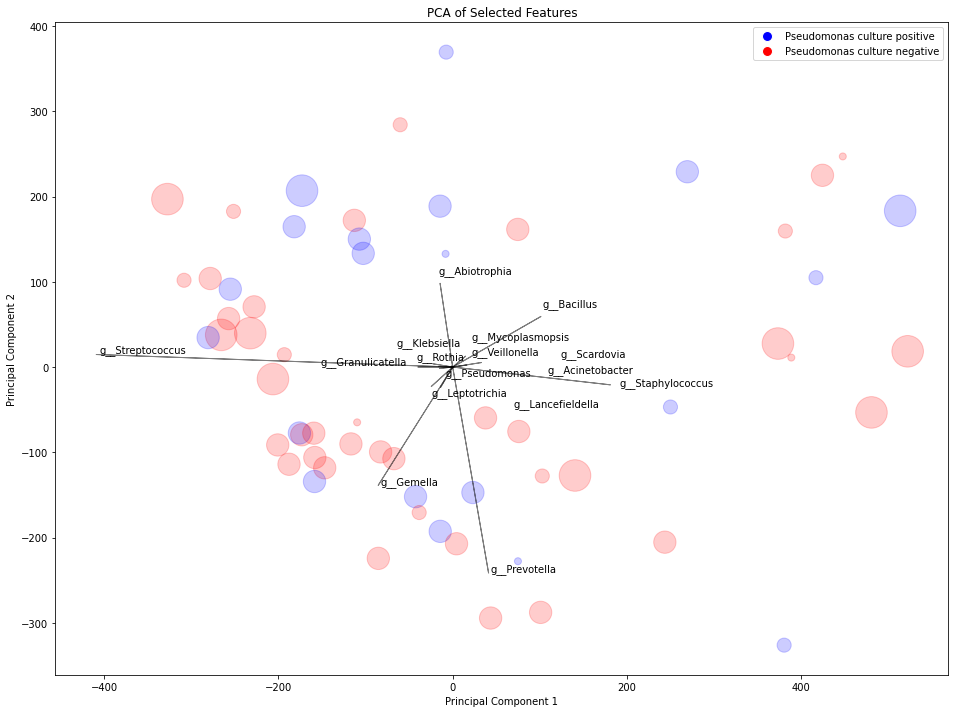

In [15]:
# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('g__Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', markersize=10)
plt.legend(handles=[blue_patch, red_patch])

# Show the plot
plt.show()

In [32]:
!pip install adjustText


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
df

taxonomy,g__Candidatus Stahlbacteria,g__Candidatus Chromulinivorax,g__Bradymonas,g__Microvenator,g__Candidatus Acididesulfobacter,g__Candidatus Acidulodesulfobacterium,g__Acanthopleuribacter,g__Candidatus Sulfopaludibacter,g__Edaphobacter,g__Granulicella,...,g__Coraliomargarita,g__Pelagicoccus,g__Puniceicoccus,g__Chthoniobacter,g__Pedosphaera,g__Akkermansia,g__Brevifollis,g__Luteolibacter,g__Verrucomicrobium,g__Candidatus Eremiobacter
825012_20181120_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
698917_20171207_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1586713_20180309_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
748160_20180321_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1593973_20180504_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.775989,0.000000
1316979_20171215_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17.962674,0.000000,0.000000,0.000000,0.000000
756934_20181218_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,41.144362,0.000000,0.000000,0.000000,0.000000
983493_20180123_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
892355_20180123_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1651490_20171010_S,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,30.430284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
